# ERA5 vs CERRA Extremes

## Import packages

In [1]:
import calendar

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Select time range
year_start = 1985
year_stop = 1985

# Select month of interest
month = 8
assert month in range(1, 13), f"{month=} is invalid"

# Select region of interest
region = "Lazio"
region_slices = {
    "Alps": {"lon_slice": slice(5, 15), "lat_slice": slice(48, 43)},
    "Scandinavia": {"lon_slice": slice(10, 42), "lat_slice": slice(72, 62)},
    "Lazio": {"lon_slice": slice(11, 14), "lat_slice": slice(43, 41)},
    "Italy": {"lon_slice": slice(6, 19), "lat_slice": slice(48, 36)},
}
assert region in region_slices, f"{region=} is invalid"

## Define request

In [3]:
requests_dict = {
    "reanalysis-cerra-single-levels": {
        "variable": "2m_temperature",
        "level_type": "surface_or_atmosphere",
        "data_type": "reanalysis",
        "product_type": "analysis",
        "time": [f"{i:02d}:00" for i in range(0, 24, 3)],
        "format": "grib",
    },
    "reanalysis-era5-single-levels": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
    },
    "reanalysis-era5-land": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
    },
} 

## Functions to cache

In [4]:
def regionalised_max(ds, lon_slice, lat_slice):
    time = ds["forecast_reference_time"].mean()
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    ds = ds.max("forecast_reference_time", keep_attrs=True)
    return ds.expand_dims(time=[time.values])

## Download and transform

In [5]:
dataarrays = {}
for collection_id, request in requests_dict.items():
    requests = []
    for year in range(year_start, year_stop + 1):
        time_request = {
            "year": year,
            "month": month,
            "day": list(range(1, calendar.monthrange(year, month)[1] + 1)),
        }
        requests.append(request | time_request)
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=regionalised_max,
        transform_func_kwargs=region_slices[region],
        backend_kwargs={"time_dims": ("time",)}
    )
    (varname,) = ds.data_vars
    da = ds[varname].max("time", keep_attrs=True)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    dataarrays[collection_id] = da

100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


## Plot maps

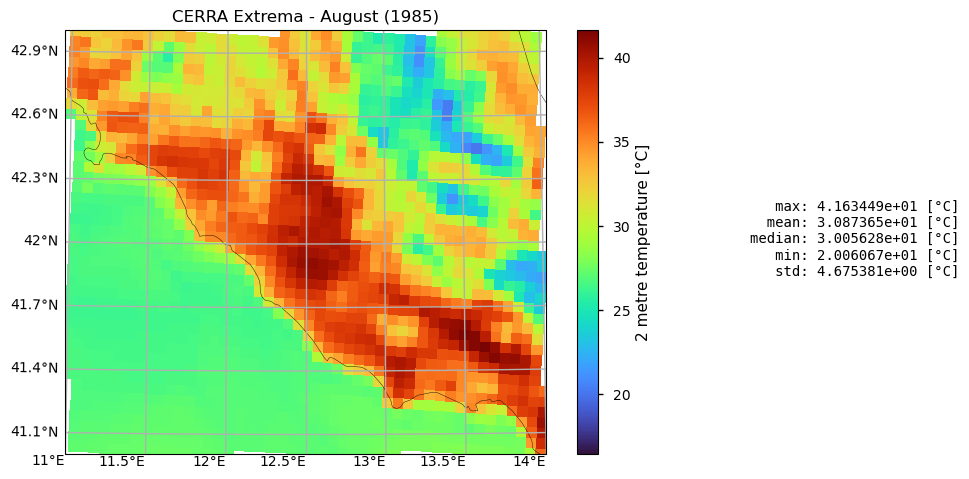

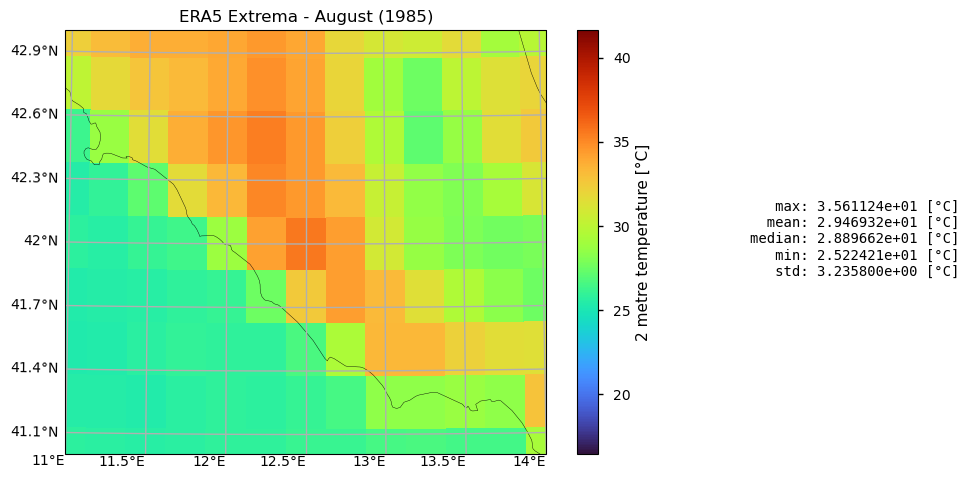

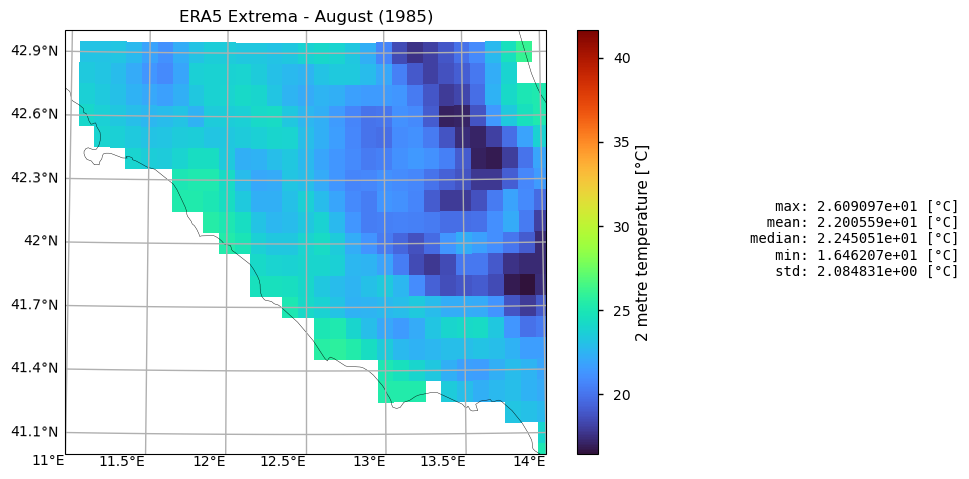

In [6]:
# Set common cbar and projection
vmin = min([da.min().values for da in dataarrays.values()])
vmax = max([da.max().values for da in dataarrays.values()])
lon_slice = region_slices[region]["lon_slice"]
lat_slice = region_slices[region]["lat_slice"]
projection = ccrs.LambertConformal(
    central_longitude=(lon_slice.start + lon_slice.stop) / 2,
    central_latitude=(lat_slice.start + lat_slice.stop) / 2,
)
extent = [
    min(lon_slice.start, lon_slice.stop),
    max(lon_slice.start, lon_slice.stop),
    min(lat_slice.start, lat_slice.stop),
    max(lat_slice.start, lat_slice.stop),
]

# Set title
years = sorted(map(str, {year_start, year_stop}))
title = f"Extrema - {calendar.month_name[month]} ({'-'.join(years)})"

# Plot maps
for collection_id, da in dataarrays.items():
    plot.projected_map(da, projection=projection, vmin=vmin, vmax=vmax, cmap="turbo")
    plot_obj = plt.title(f"{collection_id.split('-')[1].upper()} {title}")
    plot_obj.axes.set_extent(extent)
    for gl in plot_obj.axes._gridliners:
        gl.x_inline = False
        gl.xlabel_style = {"rotation": 0}
    plt.show()

## Plot historgram

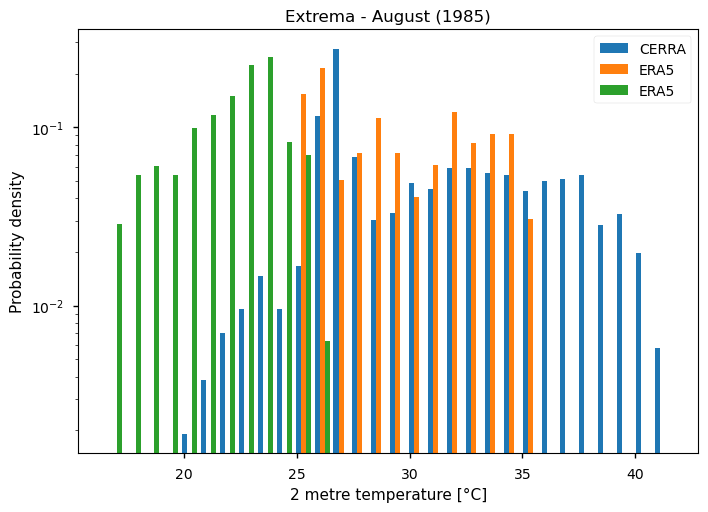

In [7]:
stacked_data = {
    collection_id: da.stack(dim=da.dims).values
    for collection_id, da in dataarrays.items()
}
fig, ax = plt.subplots()
ax.hist(
    stacked_data.values(),
    bins=30,
    density=True,
    label=[label.split("-")[1].upper() for label in dataarrays],
)
ax.set_yscale("log")
ax.set_xlabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
ax.set_ylabel("Probability density")
ax.legend()
_ = ax.set_title(title)